In [15]:
import math
import pdb

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data
from torch import nn
import wandb
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
sys.path.append('../')
import simulation
from modules import AutoEncoderLayers
from utils import set_random_seed_all, print_graph_from_weights, ks_test_screen, compute_p_vals

In [19]:
dir_path = "../saved_mtxs/"
stagnated_runnames = [
    "50_100_1.00_interventions__prescreengamma_search_mask_0.3",
    "50_100_0.5_interventions__prescreengamma_search_mask_0.3",
    "50_100_0.1_interventions__prescreengamma_search_mask_0.3",
]
good_runnames = [
    "50_100_0.75_interventions__prescreengamma_search_mask_0.3",
    "50_100_0.25_interventions__prescreengamma_search_mask_0.3",
]

In [21]:
B_true = np.load(os.path.join(dir_path,f"B_true_100.npy"))

In [40]:
os.path.join(dir_path,f"mask_{good_runnames[0]}.npy")

'../saved_mtxs/mask_50_100_0.75_interventions__prescreengamma_search_mask_0.3.npy'

In [17]:
# compare masks
good_mask = np.load(os.path.join(dir_path,f"mask_{good_runnames[0]}.npy"))
good_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<Axes: >

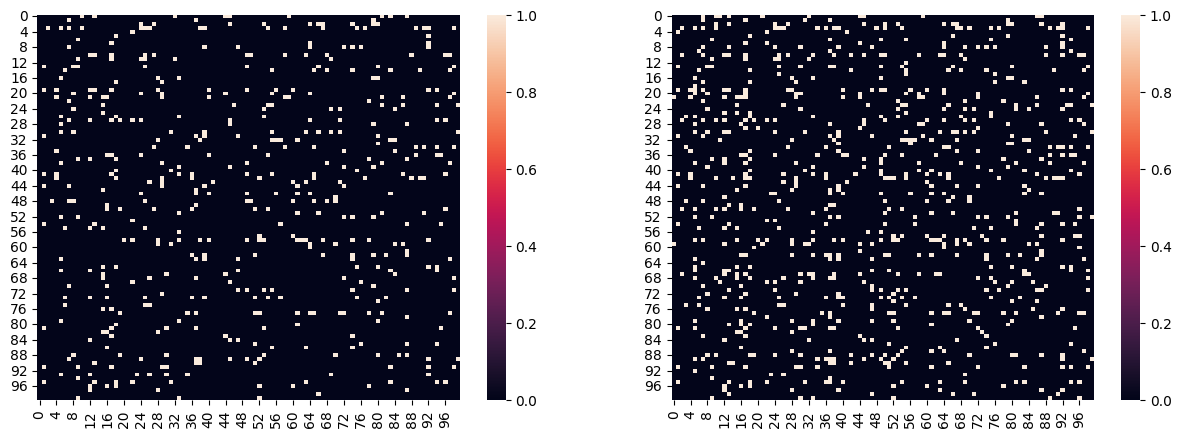

In [25]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(B_true, ax=axs[0])
sns.heatmap(good_mask, ax=axs[1])

In [26]:
# compare masks
bad_mask = np.load(os.path.join(dir_path,f"mask_{stagnated_runnames[0]}.npy"))
bad_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<Axes: >

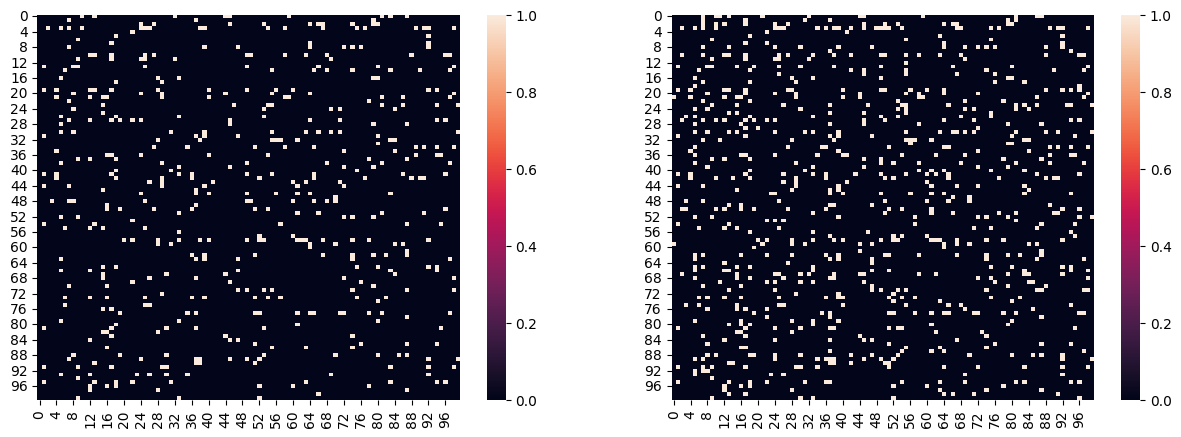

In [28]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(B_true, ax=axs[0])
sns.heatmap(bad_mask, ax=axs[1])

<Axes: >

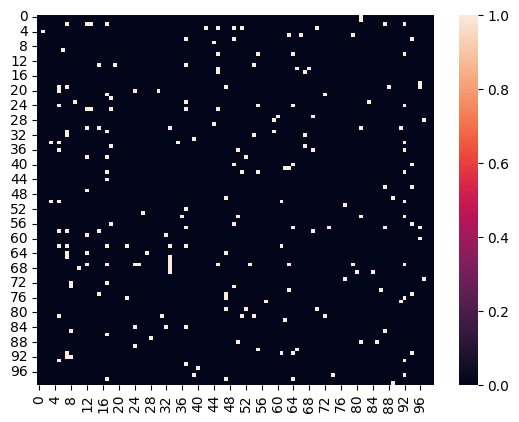

In [29]:
sns.heatmap(good_mask != bad_mask)

In [31]:
good_final = np.load(os.path.join(dir_path,f"final_{good_runnames[0]}.npy"))
bad_final = np.load(os.path.join(dir_path,f"final_{stagnated_runnames[0]}.npy"))

<Axes: >

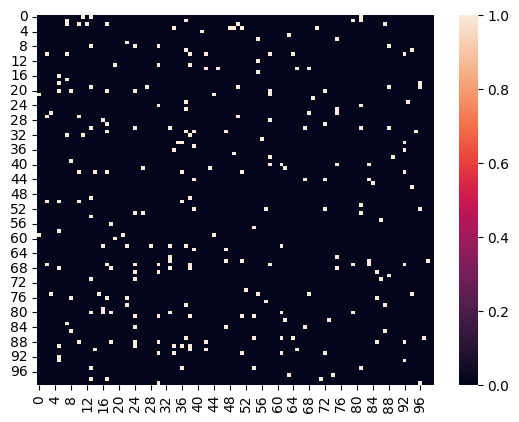

In [38]:
sns.heatmap((good_final > 0.3) != (bad_final > 0.3))

<Axes: >

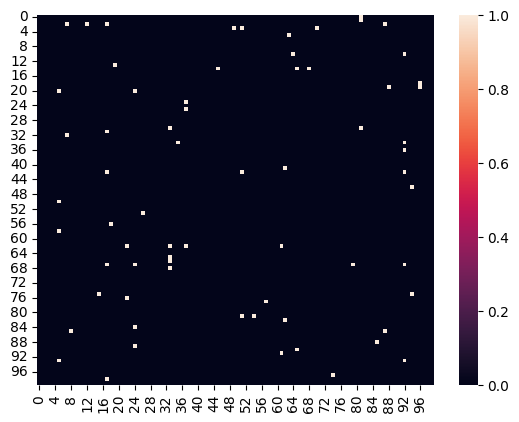

In [39]:
(good_final > 0.3) != (bad_final > 0.3)

<Axes: >

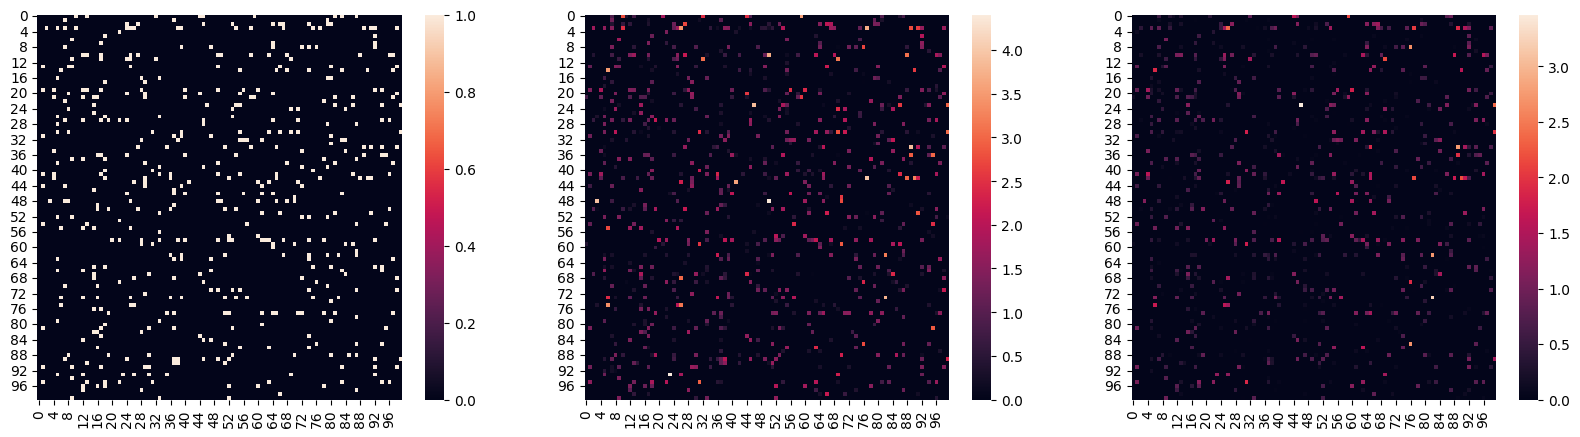

In [41]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
sns.heatmap(B_true, ax=axs[0])
sns.heatmap(bad_final, ax=axs[1])
sns.heatmap(good_final, ax=axs[2])

In [42]:
print(good_mask.sum(), bad_mask.sum())

815 791


In [47]:
(good_mask.astype(bool) != (bad_mask.astype(bool))).sum()

214

In [45]:
(good_mask.astype(bool) & ~(bad_mask.astype(bool))).sum()

119

In [48]:
(~good_mask.astype(bool) & (bad_mask.astype(bool))).sum()

95

In [49]:
custom_mask = (bad_mask.astype(bool) | good_mask.astype(bool)).astype(int)
np.save(os.path.join(dir_path,f"custom_mask.npy"), custom_mask)

<Axes: >

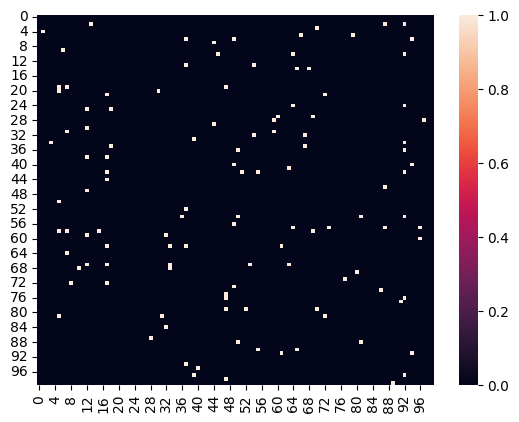

In [50]:
sns.heatmap((good_mask.astype(bool) & ~(bad_mask.astype(bool))))

In [55]:
missing_idxs = np.where(good_mask.astype(bool) & ~(bad_mask.astype(bool)))
n_missing = len(missing_idxs[0])

In [58]:
for i in range(5):
    random_add_mask_choices = np.random.choice(n_missing, n_missing // 2, replace=False)
    random_add_mask = np.zeros(bad_mask.shape)
    random_add_mask_idxs = (missing_idxs[0][random_add_mask_choices], missing_idxs[1][random_add_mask_choices])
    random_add_mask[random_add_mask_idxs] = 1
    np.save(os.path.join(dir_path,f"custom_mask_{i}.npy"), (bad_mask.astype(bool) | random_add_mask.astype(bool)).astype(int))

In [69]:
custom_masks = [np.load(os.path.join(dir_path,f"custom_mask_{i}.npy")).astype(bool) for i in range(5)]

In [71]:
missing_idxs = np.where(custom_masks[3].astype(bool) & ~(bad_mask.astype(bool)))
n_missing = len(missing_idxs[0])
n_missing

59

In [72]:
for i in range(5):
    random_add_mask_choices = np.random.choice(n_missing, n_missing // 3, replace=False)
    random_add_mask = np.zeros(bad_mask.shape)
    random_add_mask_idxs = (missing_idxs[0][random_add_mask_choices], missing_idxs[1][random_add_mask_choices])
    random_add_mask[random_add_mask_idxs] = 1
    np.save(os.path.join(dir_path,f"custom_mask_2_{i}.npy"), (bad_mask.astype(bool) | random_add_mask.astype(bool)).astype(int))

In [99]:
common_agg_custom_mask = (((custom_masks[0].astype(int) + custom_masks[1].astype(int) + custom_masks[2].astype(int) + custom_masks[4].astype(int)) >= 3) & ~bad_mask)
np.save(os.path.join(dir_path,f"common_agg_custom_mask.npy"), (bad_mask.astype(bool) | common_agg_custom_mask.astype(bool)).astype(int))

(array([33.,  0.,  0., 46.,  0.,  0., 25.,  0.,  0.,  9.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

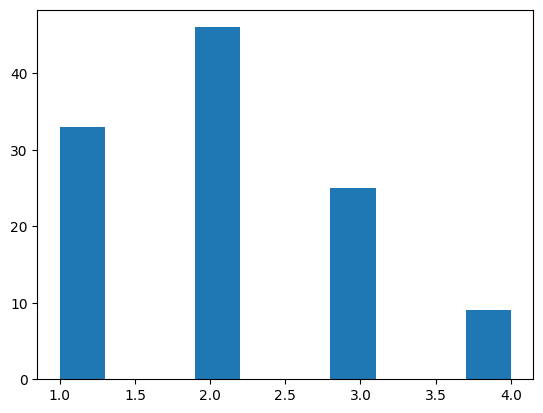

In [98]:
all_el = ((custom_masks[0].astype(int) + custom_masks[1].astype(int) + custom_masks[2].astype(int) + custom_masks[4].astype(int)))
all_el = all_el[np.where((1 - bad_mask).astype(bool))]

plt.hist(all_el[all_el > 0].flatten())

In [96]:
all_el[np.where((1 - bad_mask).astype(bool))].shape

(9209,)

In [95]:
np.where((1 - bad_mask).astype(bool))[0].shape

(9209,)

In [100]:
common_agg_custom_mask.sum()

34

<Axes: >

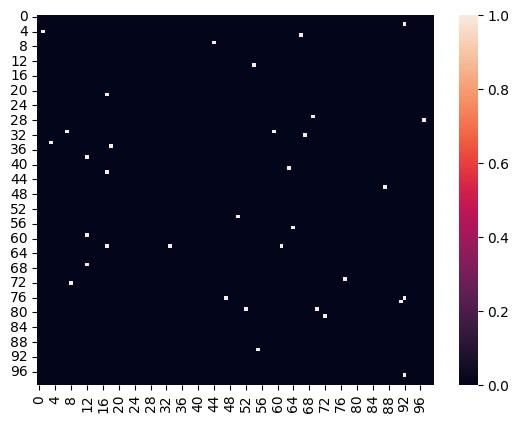

In [101]:
sns.heatmap(common_agg_custom_mask)

In [112]:
final_common_agg_custom_mask = np.load(os.path.join(dir_path,f"final_start_from_common_agg_custom_mask.npy")) > 0.3
final_custom_3_mask = np.load(os.path.join(dir_path,f"final_start_from_custom_mask_3.npy")) > 0.3

<Axes: >

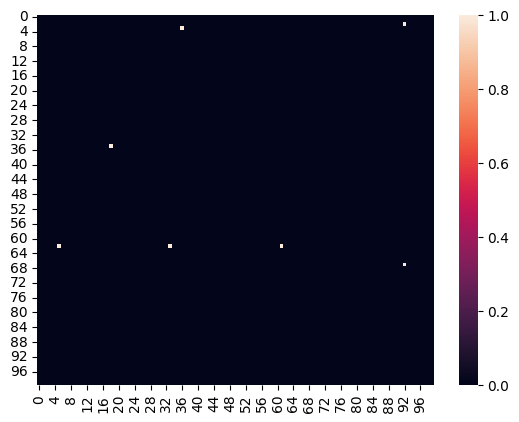

In [113]:
sns.heatmap(final_common_agg_custom_mask.astype(bool) & ~final_custom_3_mask.astype(bool))

<Axes: >

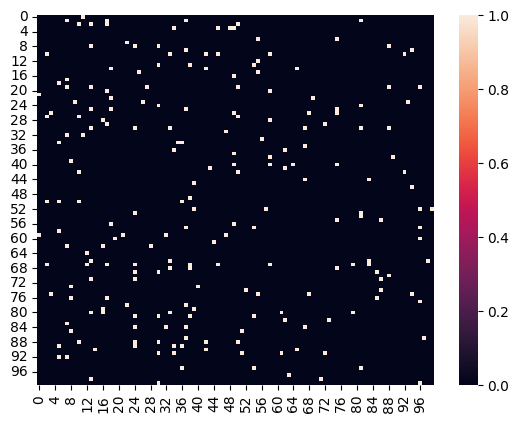

In [114]:
sns.heatmap(~final_common_agg_custom_mask.astype(bool) & final_custom_3_mask.astype(bool))

In [120]:
(common_agg_custom_mask.astype(bool) & B_true.astype(bool)).sum()

0